## Import packages and set working directory

In [31]:
import matplotlib
% matplotlib inline
import numpy as np
import scipy
import scipy.stats as stats
import scipy.optimize as optimize
import scipy.integrate as integrate
from __future__ import print_function, division
import BUM
import neuropower
import os
import math
from nipy.labs.utils.simul_multisubject_fmri_dataset import surrogate_3d_dataset
from nipype.interfaces import fsl
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd
from palettable.colorbrewer.qualitative import Paired_7
import scipy.stats as stats


In [2]:
os.chdir("/Users/Joke/Documents/Onderzoek/Studie_7_newpower/WORKDIR/")

## Define peak density function 

In [3]:
def peakdens3D(x,k):
    fd1 = 144*stats.norm.pdf(x)/(29*6**(0.5)-36)
    fd211 = k**2.*((1.-k**2.)**3. + 6.*(1.-k**2.)**2. + 12.*(1.-k**2.)+24.)*x**2. / (4.*(3.-k**2.)**2.)
    fd212 = (2.*(1.-k**2.)**3. + 3.*(1.-k**2.)**2.+6.*(1.-k**2.)) / (4.*(3.-k**2.))
    fd213 = 3./2.
    fd21 = (fd211 + fd212 + fd213)
    fd22 = np.exp(-k**2.*x**2./(2.*(3.-k**2.))) / (2.*(3.-k**2.))**(0.5)
    fd23 = stats.norm.cdf(2.*k*x / ((3.-k**2.)*(5.-3.*k**2.))**(0.5))
    fd2 = fd21*fd22*fd23
    fd31 = (k**2.*(2.-k**2.))/4.*x**2. - k**2.*(1.-k**2.)/2. - 1.
    fd32 = np.exp(-k**2.*x**2./(2.*(2.-k**2.))) / (2.*(2.-k**2.))**(0.5)
    fd33 = stats.norm.cdf(k*x / ((2.-k**2.)*(5.-3.*k**2.))**(0.5))
    fd3 = fd31 * fd32 * fd33
    fd41 = (7.-k**2.) + (1-k**2)*(3.*(1.-k**2.)**2. + 12.*(1.-k**2.) + 28.)/(2.*(3.-k**2.))
    fd42 = k*x / (4.*math.pi**(0.5)*(3.-k**2.)*(5.-3.*k**2)**0.5)
    fd43 = np.exp(-3.*k**2.*x**2/(2.*(5-3.*k**2.)))
    fd4 = fd41*fd42 * fd43
    fd51 = math.pi**0.5*k**3./4.*x*(x**2.-3.)
    f521low = np.array([-10.,-10.])
    f521up = np.array([0.,k*x/2.**(0.5)])
    f521mu = np.array([0.,0.])
    f521sigma = np.array([[3./2., -1.],[-1.,(3.-k**2.)/2.]])
    fd521,i = stats.mvn.mvnun(f521low,f521up,f521mu,f521sigma) 
    f522low = np.array([-10.,-10.])
    f522up = np.array([0.,k*x/2.**(0.5)])
    f522mu = np.array([0.,0.])
    f522sigma = np.array([[3./2., -1./2.],[-1./2.,(2.-k**2.)/2.]])
    fd522,i = stats.mvn.mvnun(f522low,f522up,f522mu,f522sigma) 
    fd5 = fd51*(fd521+fd522)
    out = fd1*(fd2+fd3+fd4+fd5)
    return out

## Simulate and export data from 10 subjects 

/Users/Joke/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


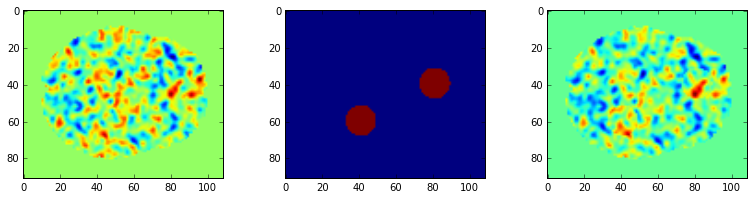

In [6]:
smooth_FWHM = 3
smooth_sigma = smooth_FWHM/(2*math.sqrt(2*math.log(2)))
dimensions = (50,50,50)
positions = np.array([[60,40,40],
                   [40,80,40],
                   [50,30,60]])
amplitudes = np.array([1.,1.,1.])
width = 5.
seed=123
mask = nib.load("mask.nii")
nsub=10

noise = surrogate_3d_dataset(n_subj=nsub, shape=dimensions, mask=mask, 
                             sk=smooth_sigma,noise_level=1.0, 
                             width=5.0,out_text_file=None, 
                             out_image_file=None, seed=seed)
signal = surrogate_3d_dataset(n_subj=nsub, shape=dimensions, mask=mask, 
                             sk=smooth_sigma,noise_level=0.0, pos=positions, 
                             ampli=amplitudes, width=10.0,out_text_file=None, 
                             out_image_file=None, seed=seed)
low_values_indices = signal < 0.1
signal[low_values_indices] = 0
high_values_indices = signal > 0
signal[high_values_indices] = 1
data = noise+signal

fig,axs=plt.subplots(1,3,figsize=(13,3))
fig.subplots_adjust(hspace = .5, wspace=0.3)
axs=axs.ravel()
axs[0].imshow(noise[1,:,:,40])
axs[1].imshow(signal[1,:,:,40])
axs[2].imshow(data[1,:,:,40])
fig.show()


In [7]:
data = data.transpose((1,2,3,0))
img=nib.Nifti1Image(data,np.eye(4))
img.to_filename(os.path.join("simulated_dataset.nii.gz"))

## Perform group analysis and extract peaks from Tstat-map

In [8]:
model=fsl.L2Model(num_copes=nsub)
model.run()

In [9]:
flameo=fsl.FLAMEO(cope_file='simulated_dataset.nii.gz', 
                  cov_split_file='design.grp', 
                  design_file='design.mat',
                  t_con_file='design.con',
                  mask_file='mask.nii',
                  run_mode='ols',
                  terminal_output='none')
flameo.run()

In [10]:
tstat = nib.load("stats/tstat1.nii.gz").get_data()

minimum = np.nanmin(tstat)
newdata = tstat - minimum #little trick because fsl.model.Cluster ignores negative values
img=nib.Nifti1Image(newdata,np.eye(4))
img.to_filename(os.path.join("tstat1_allpositive.nii.gz"))
cl=fsl.model.Cluster()
cl.inputs.threshold = 0
cl.inputs.in_file=os.path.join("tstat1_allpositive.nii.gz")
cl.inputs.out_localmax_txt_file=os.path.join("locmax.txt")
cl.inputs.num_maxima=10000
cl.inputs.connectivity=26
cl.inputs.terminal_output='none'
cl.run()


In [151]:
peaks = pd.read_csv("locmax.txt",sep="\t").drop('Unnamed: 5',1)
peaks.Value = peaks.Value + minimum

## Plot observed distribution of peaks with theoretical distribution (under H_0)

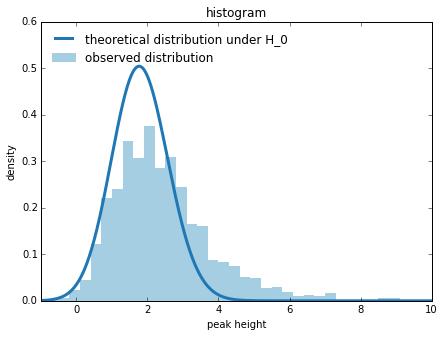

In [13]:
xn = np.arange(-10,10,0.01)
yn = []
for x in xn:
    yn.append(peakdens3D(x,1))

twocol = Paired_7.mpl_colors
plt.figure(figsize=(7,5))
plt.hist(peaks.Value,lw=0,facecolor=twocol[0],normed=True,bins=np.arange(-5,10,0.3),label="observed distribution")
plt.xlim([-1,10])
plt.ylim([0,0.6])
plt.plot(xn,yn,color=twocol[1],lw=3,label="theoretical distribution under H_0")
plt.title("histogram")
plt.xlabel("peak height")
plt.ylabel("density")
plt.legend(loc="upper left",frameon=False)
plt.show()

## Compute p-values based on theoretical distribution (by numerical integration) 

In [15]:
y = []
for x in peaks.Value:
    y.append(1-integrate.quad(lambda x: peakdens3D(x,1), -20, x)[0])

ynew = [10**(-6) if x<10**(-6) else x for x in y]
peaks.P = ynew

## Compute proportion of activation based on BUM model

In [17]:
bum = BUM.bumOptim(peaks.P,starts=100)
bum["pi1"]

0.35285652371190734

## Plot histogram of p-values with expected distribution (beta and uniform) 

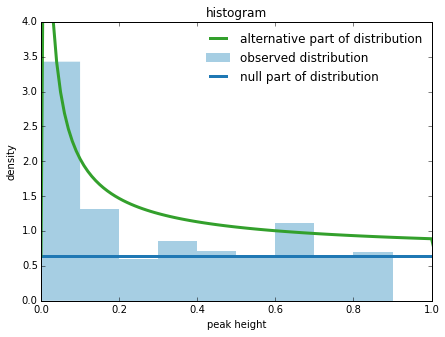

In [18]:
twocol = Paired_7.mpl_colors
plt.figure(figsize=(7,5))
plt.hist(peaks.P,lw=0,facecolor=twocol[0],normed=True,bins=np.arange(0,1,0.1),label="observed distribution")
plt.hlines(1-bum["pi1"],0,1,color=twocol[1],lw=3,label="null part of distribution")
plt.plot(xn,stats.beta.pdf(xn,bum["a"],1)+1-bum["pi1"],color=twocol[3],lw=3,label="alternative part of distribution")
plt.xlim([0,1])
plt.ylim([0,4])
plt.title("histogram")
plt.xlabel("peak height")
plt.ylabel("density")
plt.legend(loc="upper right",frameon=False)
plt.show()

## Apply power procedure WITH threshold 

In [20]:
powerthres = neuropower.peakmixmodfit(peaks.Value[peaks.Value>3],bum["pi1"],3)
print(powerthres["mu"])
print(powerthres["sigma"])

5.44416516215
0.924578530841


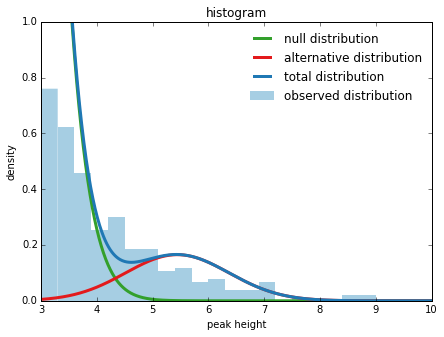

In [153]:
twocol = Paired_7.mpl_colors
plt.figure(figsize=(7,5))
plt.hist(peaks.Value[peaks.Value>3],lw=0,facecolor=twocol[0],normed=True,bins=np.arange(3,10,0.3),label="observed distribution")
plt.xlim([3,10])
plt.ylim([0,1])
plt.plot(xn,neuropower.nulprobdens(3,xn)*(1-bum["pi1"]),color=twocol[3],lw=3,label="null distribution")
plt.plot(xn,neuropower.altprobdens(powerthres["mu"],powerthres["sigma"],3,xn)*(bum["pi1"]),color=twocol[5],lw=3, label="alternative distribution")
plt.plot(xn,neuropower.mixprobdens(powerthres["mu"],powerthres["sigma"],bum["pi1"],3,xn),color=twocol[1],lw=3,label="total distribution")
plt.title("histogram")
plt.xlabel("peak height")
plt.ylabel("density")
plt.legend(loc="upper right",frameon=False)
plt.show()

## Adjust power procedure without threshold

In [137]:
def altprobdens(mu,sigma,peaks):
	out = scipy.stats.norm(mu,sigma).pdf(peaks)
	return out

def mixprobdens(mu,sigma,pi1,peaks):
        f0=[(1-pi1)*peakdens3D(p,1) for p in peaks]
        fa=[pi1*altprobdens(mu,sigma,p) for p in peaks]
        f=[x + y for x, y in zip(f0, fa)]
	return(f)

def mixprobdensSLL(pars,pi1,peaks):
	mu=pars[0]
	sigma=pars[1]
	f = mixprobdens(mu,sigma,pi1,peaks)
	LL = -sum(np.log(f))
	return(LL)

def nothrespeakmixmodfit(peaks,pi1):
	"""Searches the maximum likelihood estimator for the mixture distribution of null and alternative"""
	start = [5,0.5]
	opt = scipy.optimize.minimize(mixprobdensSLL,start,method='L-BFGS-B',args=(pi1,peaks),bounds=((2.5,50),(0.1,50)))
	out={'maxloglikelihood': opt.fun,
		'mu': opt.x[0],
		'sigma': opt.x[1]}
	return out

In [140]:
modelfit = nothrespeakmixmodfit(peaks,bum["pi1"])

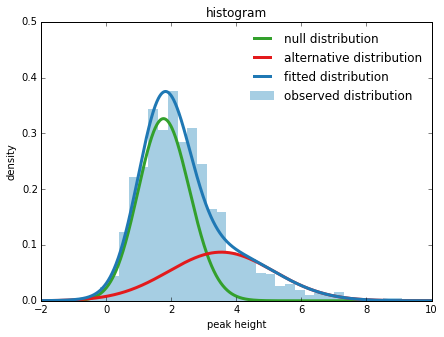

In [155]:
twocol = Paired_7.mpl_colors
plt.figure(figsize=(7,5))
plt.hist(peaks.Value,lw=0,facecolor=twocol[0],normed=True,bins=np.arange(-2,10,0.3),label="observed distribution")
plt.xlim([-2,10])
plt.ylim([0,0.5])
plt.plot(xn,[(1-bum["pi1"])*peakdens3D(p,1) for p in xn],color=twocol[3],lw=3,label="null distribution")
plt.plot(xn,bum["pi1"]*altprobdens(modelfit["mu"],modelfit["sigma"],xn),color=twocol[5],lw=3,label="alternative distribution")
plt.plot(xn,mixprobdens(modelfit["mu"],modelfit["sigma"],bum["pi1"],xn),color=twocol[1],lw=3,label="fitted distribution")
plt.title("histogram")
plt.xlabel("peak height")
plt.ylabel("density")
plt.legend(loc="upper right",frameon=False)
plt.show()